## Rayleigh Taylor Instability Benchmark

This notebook implements the isoviscous thermochemical convection benchmark from van Keken et al (1997).

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = 
    \left( Ra _T T + Ra _\Gamma \Gamma \right) \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

The thermal and compositional evolution is controlled by advection and (thermal) diffusion

$$
    \frac{D T}{D t} = \nabla^2 T 
$$    

$$
    \frac{D \Gamma}{D t} = 0
$$

Thermal and compositional Rayleigh numbers are defined by

$$ 
    Ra _T = \frac{g \rho \alpha \Delta T h ^3}{\kappa \eta _r} ; \;\;\;\; 
    Ra _\Gamma = \frac{g \Delta \rho _\Gamma h ^3}{\kappa \eta _r}
$$




van Keken, P. E., S. D. King, H. Schmeling, U. R. Christensen, D. Neumeister, and M. P. Doin (1997), A comparison of methods for the modeling of thermochemical convection, J. Geophys. Res., 102(B10), 22477, doi:10.1029/97JB01353.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

In [2]:
dim = 2

In [3]:
# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0', 
                                         elementRes=(64,64), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(0.9142,1.) )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [4]:
# create fevariables
velocityField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )

In [5]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [6]:
# Get list of special sets.
# These are sets of vertices on the mesh. In this case we want to set them as boundary conditions.
linearMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

In [7]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

In [8]:
# You can view the contents of the sets directly
IWalls

FeMesh_IndexSet([   0,   64,   65,  129,  130,  194,  195,  259,  260,  324,  325,
        389,  390,  454,  455,  519,  520,  584,  585,  649,  650,  714,
        715,  779,  780,  844,  845,  909,  910,  974,  975, 1039, 1040,
       1104, 1105, 1169, 1170, 1234, 1235, 1299, 1300, 1364, 1365, 1429,
       1430, 1494, 1495, 1559, 1560, 1624, 1625, 1689, 1690, 1754, 1755,
       1819, 1820, 1884, 1885, 1949, 1950, 2014, 2015, 2079, 2080, 2144,
       2145, 2209, 2210, 2274, 2275, 2339, 2340, 2404, 2405, 2469, 2470,
       2534, 2535, 2599, 2600, 2664, 2665, 2729, 2730, 2794, 2795, 2859,
       2860, 2924, 2925, 2989, 2990, 3054, 3055, 3119, 3120, 3184, 3185,
       3249, 3250, 3314, 3315, 3379, 3380, 3444, 3445, 3509, 3510, 3574,
       3575, 3639, 3640, 3704, 3705, 3769, 3770, 3834, 3835, 3899, 3900,
       3964, 3965, 4029, 4030, 4094, 4095, 4159, 4160, 4224])

In [9]:
JWalls

FeMesh_IndexSet([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64, 4160,
       4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171,
       4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182,
       4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193,
       4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204,
       4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215,
       4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224])

In [10]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
AllWalls = IWalls + JWalls

freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(AllWalls,JWalls) )

In [11]:
# We create swarms of particles which can advect, and which may determine 'materials'
gSwarm = uw.swarm.Swarm( feMesh=elementMesh )

# Now we add a data variable which will store an index to determine material
materialVariable = gSwarm.add_variable( dataType="char", count=1 )

# Layouts are used to populate the swarm across the whole domain
# Create the layout object
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=20 )
# Now use it to populate.
gSwarm.populate_using_layout( layout=layout )

In [12]:
# Lets initialise the 'materialVariable' data to represent two different materials. 
materialHeavyIndex = 0
materialLightIndex = 1

# Now let's initialize the materialVariable with the required perturbation
import math
wavelength = 1.8284
amplitude  = 0.02
offset     = 0.2
k = 2.*math.pi / wavelength
coordinate = fn.input()
materialVariable.data[:] = fn.branching.conditional( 
    [ ( offset + amplitude*fn.math.cos( k*coordinate[0] ) > coordinate[1] , materialLightIndex ),
      (                                                              True , materialHeavyIndex )  ] ).evaluate(gSwarm)

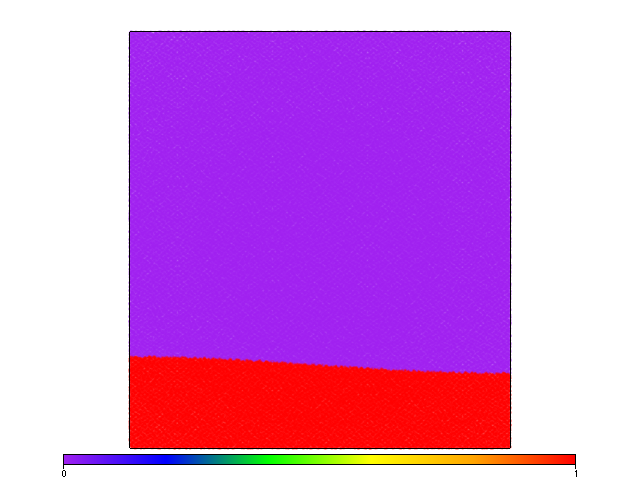

In [13]:
# visualise
fig1 = plt.Figure()
fig1.Points( swarm=gSwarm, colourVariable=materialVariable, pointSize=5.0 )
fig1.show()

In [14]:
# We create some functions here.
# The Map function allows as to create 'per material' type behaviour.  
# It requires a 'keyFunc', which is first evaluate to determine the key
# into the map, and then once the key is determine, we retrieve the value (ie function)
# it maps to, and evaluate that. 

# Here we set a viscosity value of '1.' for both materials 
viscosityMapFn = fn.branching.map( keyFunc = materialVariable, 
                         mappingDict = { materialLightIndex:1., materialHeavyIndex:1. } )
# Here we set a density of '0.' for the lightMaterial, and '1.' for the heavymaterial.
densityFn      = fn.branching.map( keyFunc = materialVariable,
                         mappingDict = { materialLightIndex:0., materialHeavyIndex:1. } )
# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, -1.0 )
# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading
buoyancyFn = gravity*densityFn

In [15]:
# Setup a stokes system
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              swarm=gSwarm, 
                              conditions=[freeslipBC,],
                              viscosityFn=viscosityMapFn, 
                              bodyForceFn=buoyancyFn )

In [16]:
# Create advector objects to advect the swarms. We specify second order integration.
advector = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2 )
# Also create some integral objects which are used to calculate statistics.
v2sum_integral  = uw.utils.Integral( feMesh=linearMesh, fn=fn.math.dot(velocityField,velocityField) )
volume_integral = uw.utils.Integral( feMesh=linearMesh, fn=1. )

In [17]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0
# Perform 3 steps
while step<3:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size
    advector.integrate(dt)
    # Calculate the RMS velocity
    v2sum = v2sum_integral.integrate()
    volume = volume_integral.integrate()
    vrms = math.sqrt(v2sum[0]/volume[0])
    print 'step =',step, 'time =', time, 'vrms = ', vrms
    # Increment
    time += dt
    step += 1

step = 0 time = 0.0 vrms =  0.00018493383262
step = 1 time = 17.0335742504 vrms =  0.00021780294623
step = 2 time = 31.4523449745 vrms =  0.000254973326893


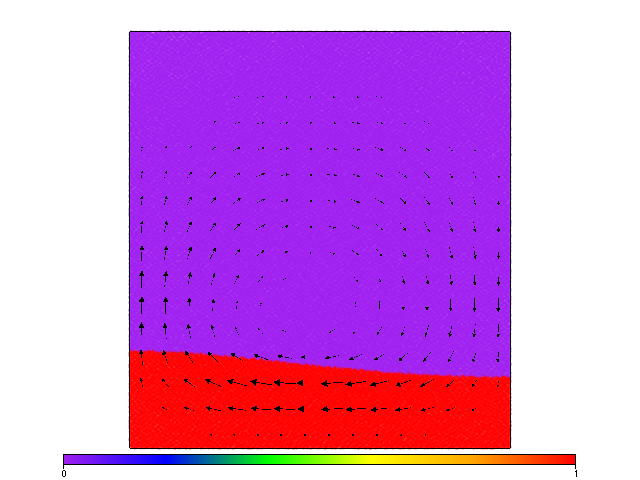

In [18]:
fig1 = plt.Figure()
fig1.Points( swarm=gSwarm, colourVariable=materialVariable, pointSize=5.0 )
fig1.VectorArrows( velocityField, elementMesh, lengthScale=100, arrowHeadSize=0.3  )
fig1.show()